In [1]:
from z3 import *
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as mpatches
import time


In [31]:

def read_instance_text(f):
    print(f)
    file = open(f)
    width = int(file.readline())
    # print("width ", width)
    n_piece = int(file.readline())
    pieces = []
    for i in range(n_piece):
        piece = file.readline()
        split_piece = piece.strip().split(" ")
        pieces.append((int(split_piece[0]), int(split_piece[1])))
    # print(pieces)
    return width, tuple(pieces)


def show_shape(s, title, n_circuits):
    """
    create a image with s as image and title as title of the graph
    :param s:
    :param title:
    :param n_circuits:
    :return:
    """
    s = cv2.merge([s])
    img = plt.imshow(s)

    values, counts = np.unique(s, return_counts=True)
    # print(counts)
    colors = [img.cmap(img.norm(value)) for value in values]
    labels = []
    starting = 0
    if n_circuits + 1 == len(counts):
        starting = 1
        labels.append("Background")
    for i in range(starting, len(counts)):
        labels.append(f"Piece {i + 1}")
    patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(counts))]
    plt.title(title)
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(list(range(0, s.shape[1] + 1)))
    yticks = list(range(0, s.shape[0]))
    # yticks.reverse()
    plt.yticks(yticks)
    plt.ylim(top=s.shape[0])
    plt.ylim(bottom=-0.5)
    plt.xlim(left=-0.5)
    plt.xlim(right=s.shape[1])
    plt.gca().invert_yaxis()
    # plt.grid(b=True)
#     plt.savefig(f"{title}")

    plt.show()


def draw_solution(sol_shape, pieces):
    arr = np.zeros(sol_shape)
    count = 1
    area = 0
    for x_t, y_t, x, y in pieces:
        # if x == 1:
        #     x = 0
        # if y == 1:
        #     y = 0
        area += x_t * y_t
        # print(x_t, y_t, x, y)
        arr[x:x + x_t, y:y + y_t] = abs(count) * (250 / len(pieces))
        count += 1
        # print(arr)
#     print(area)
    arr = arr / np.max(arr)
    return np.rot90(arr)

def min_height(dims):
    return int(np.min([dims[i][1] for i in range(len(dims))]))

def compute_area_circuits(dims):
    return sum([dim[0]* dim[1] for dim in dims])


def dims_sol_unify(dims, sols): 
    return [(dims[i][0], dims[i][1],sols[i][0],sols[i][1]) for i in range(len(sols))]

In [48]:


def vlsi_instance(dims, width, max_height):
  """
        Variable declaration
  """
  height = Int('height')
  corner_coords = [[Int("corner_coords_%s_%s" % (i + 1, j + 1)) for j in range(2)] for i in range(len(dims))]

  x = [[Bool(f"x_{i + 1}_{j+1}") for j in range(len(dims))] for i in range(len(dims))]
  y = [[Bool(f"y_{i + 1}_{j+1}") for j in range(len(dims))] for i in range(len(dims))]

  """
        Constraint definition
  """
    # board boundaries constraints
  boundaries_c_width = [And(0 <= corner_coords[i][0], corner_coords[i][0] + dims[i][0] <= width) for i in range(len(dims))]
  boundaries_c_height = [And(0 <= corner_coords[i][1], corner_coords[i][1] + dims[i][1] <= height) for i in range(len(dims))]
  height_constraint = [And(height < max_height, height > min_height(dims))]
 
  # no overlapping constraints

  no_overlapping = []
  for i in range(len(dims)):
    for j in range(len(dims)): # to fix
      if i != j:
        no_overlapping.append(
          If(corner_coords[i][0] < corner_coords[j][0],
                corner_coords[i][0] + dims[i][0] <= corner_coords[j][0] + width * And(x[i][j], y[i][j]),
          If(corner_coords[i][1] < corner_coords[j][1],
                corner_coords[i][1] + dims[i][1] <= corner_coords[j][1] - width * And(Not(x[i][j]), y[i][j]),
          If(corner_coords[i][0] > corner_coords[j][0],
                corner_coords[i][0] - dims[j][0] >=corner_coords[j][0] + height * And(x[i][j], Not(y[i][j])),
          If(corner_coords[i][1] > corner_coords[j][1],
                corner_coords[i][1] - dims[j][1] >= corner_coords[j][1] - height * And(Not(x[i][j]), Not(y[i][j])),
                False)))))

  for i in range(len(dims)):
    for j in range(len(dims)): # to fix
      if i != j:
        no_overlapping.append(
          If(corner_coords[i][0] < corner_coords[j][0], # i to the left of j
                corner_coords[i][0] + dims[i][0] <= corner_coords[j][0] + width * And(x[i][j], y[i][j]),
          If(corner_coords[i][1] < corner_coords[j][1], # i below j
                corner_coords[i][1] + dims[i][1] <= corner_coords[j][1] - width * Not(x[i][j]),
          If(corner_coords[i][0] > corner_coords[j][0], # i to the right of j 
                corner_coords[i][0] - dims[j][0] >=corner_coords[j][0] + height * Not(y[i][j]),
          If(corner_coords[i][1] > corner_coords[j][1], # i above j 
                corner_coords[i][1] - dims[j][1] >= corner_coords[j][1] - height * Or(x[i][j],y[i][j]),
                False)))))
  all_constraints = height_constraint + boundaries_c_width  + boundaries_c_height + no_overlapping
  
  """
    Solving phase
  """
  solver = Optimize()

  solver.add(all_constraints)
  # minimizing function
  circuit_area = compute_area_circuits(dims)
  solver.minimize(height*width - circuit_area)

  if solver.check() == sat:
    m = solver.model()
    return int(m.evaluate(height).as_string()), [[int(m.evaluate(corner_coords[i][j]).as_string()) for j in range(2)] for i in range(len(dims))]
  else:
    print("Failed to find a solution")
    return None



../../instances/ins-1.txt
Solution (width, height): (8, 8), time: 1.6282607588827505e+18s


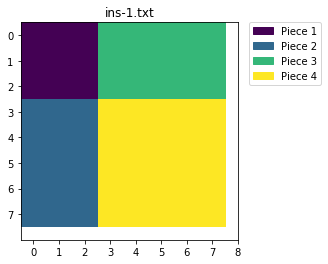

../../instances/ins-10.txt
Solution (width, height): (17, 19), time: 1.6282608125133466e+18s


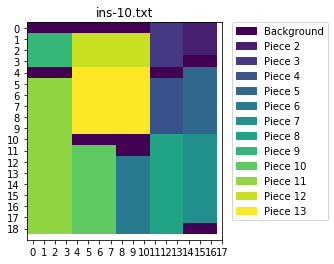

../../instances/ins-11.txt


In [ ]:
path = "../../instances/"
instances = os.listdir(path)
# instances = ["ins-3.txt"]
time_per_instance = []
for i in range(len(instances)): 
#     print(path+instance)
    instance = instances[i]
    width, dims = read_instance_text(path+instance)
    
#     print(dims)
    max_height = int(np.sum([dims[i][1] for i in range(len(dims))]))
#     print(f"Maximum height reachable: {max_height}")

    start_time = time.time_ns()
    height, solutions = vlsi_instance(dims, width, max_height)
    end_time = time.time_ns()
    end_time = end_time-start_time/ 10**9
    print(f"Solution (width, height): {width,height}, time: {round(end_time,2)}s")
    time_per_instance.append((instance, end_time))
    solutions = dims_sol_unify(dims, solutions)
    arr = draw_solution((width,height), solutions)
    show_shape(arr, instance,len(dims))


    